In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency

In [3]:
df = pd.read_csv('Data/cleaned.csv')

In [4]:
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [5]:
object_cols = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'repeated_guest', 'market_segment_type']
numeric_cols = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights','no_of_week_nights','lead_time', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled','avg_price_per_room', 'no_of_special_requests']

In [6]:
sns.set_style("whitegrid")

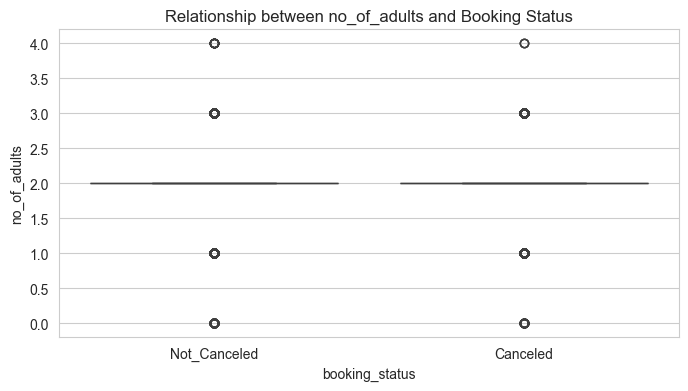

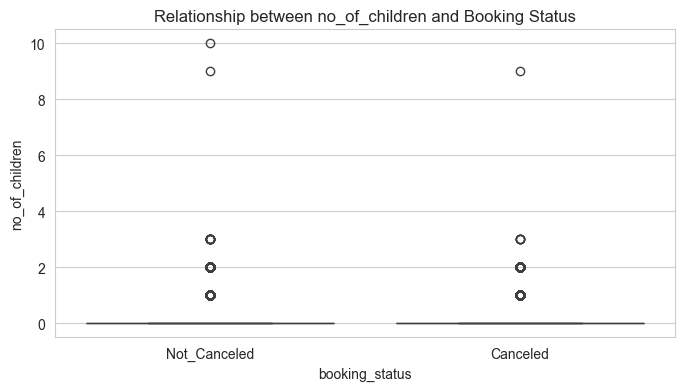

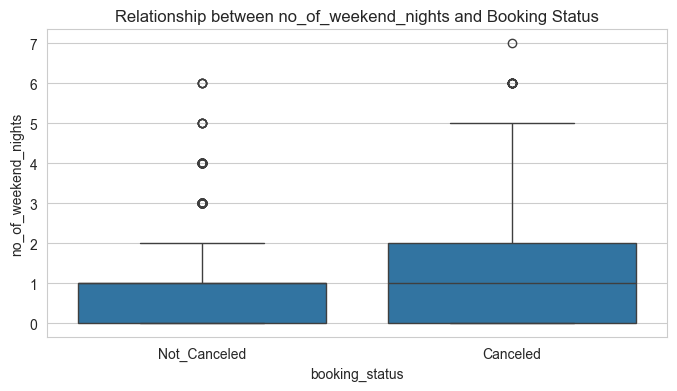

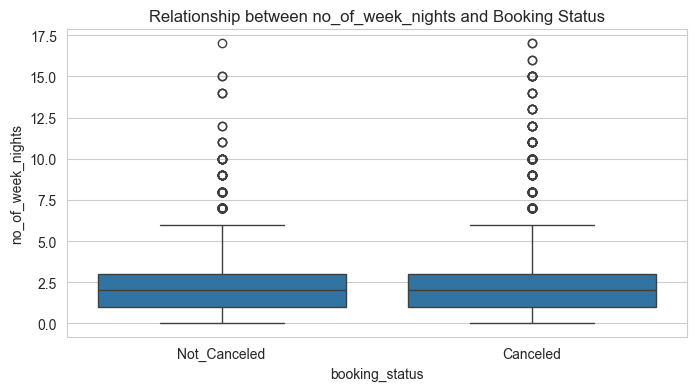

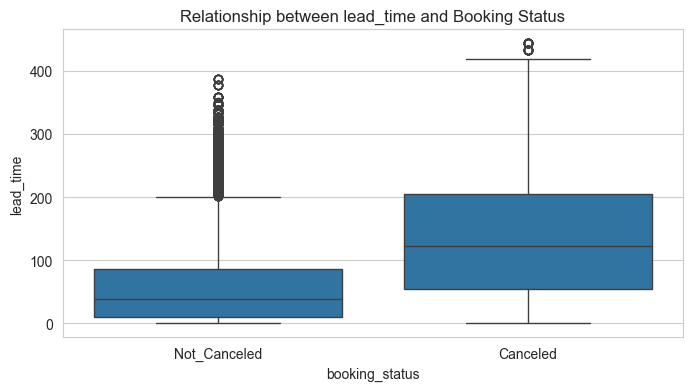

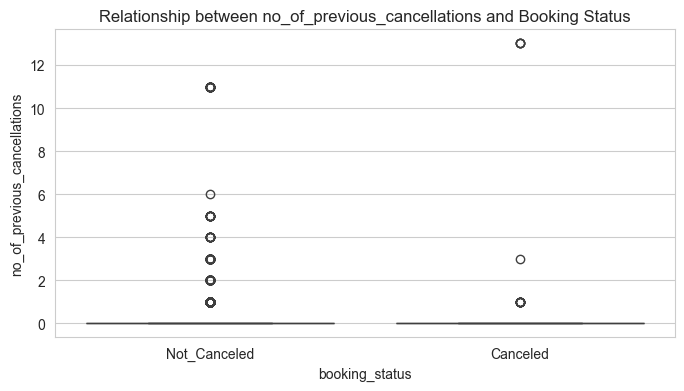

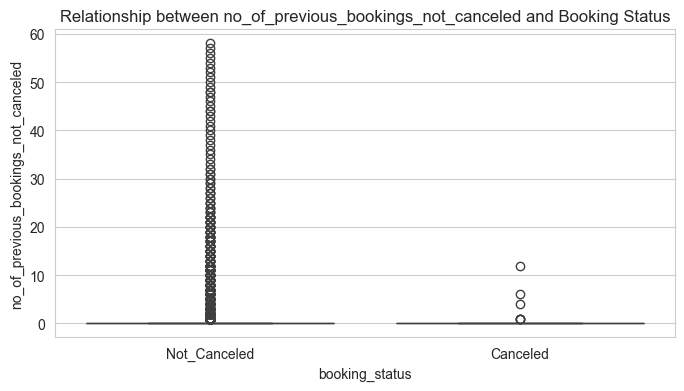

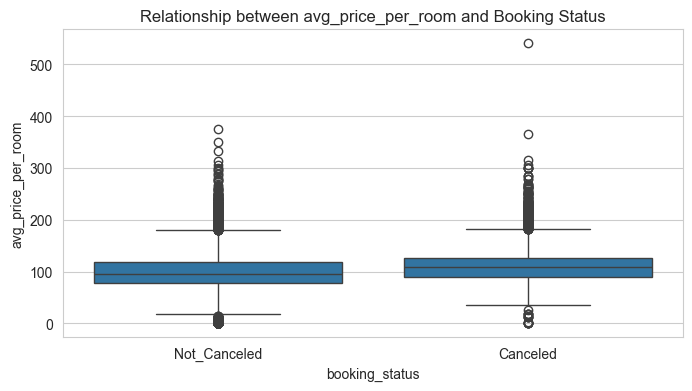

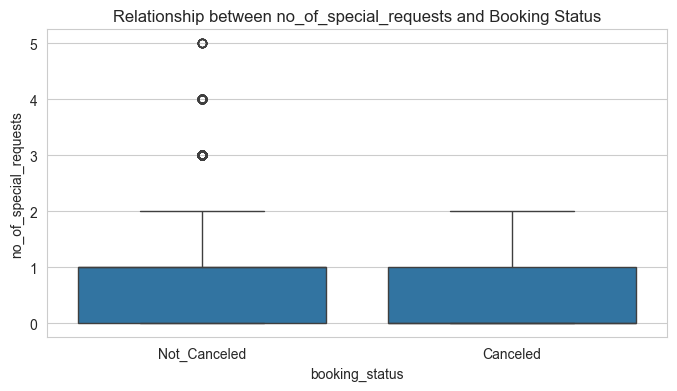

In [7]:
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='booking_status', y=col, data=df)
    plt.title(f'Relationship between {col} and Booking Status')
    plt.show()

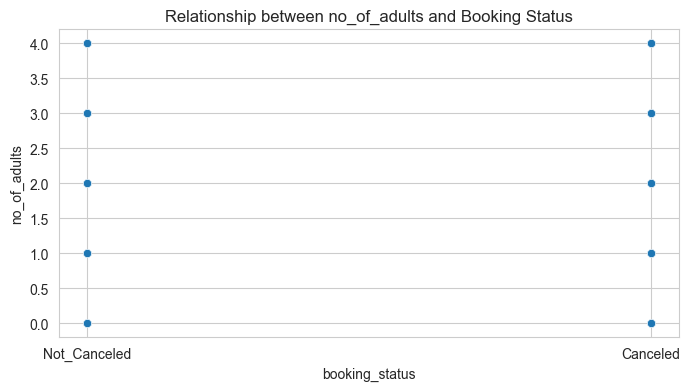

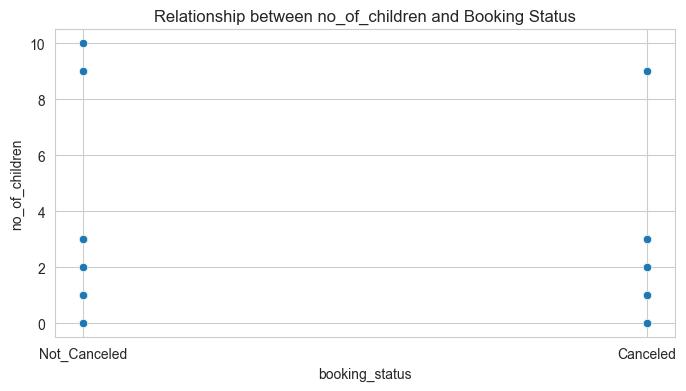

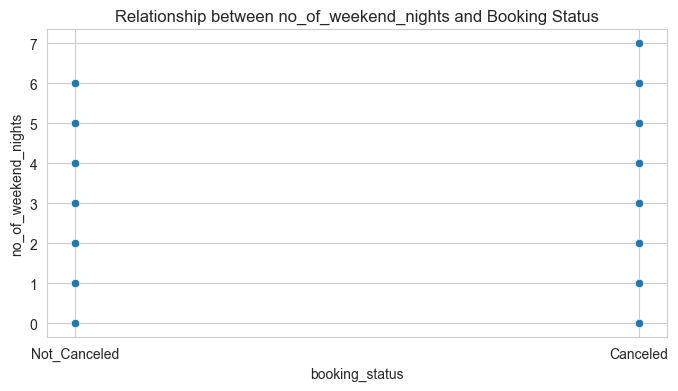

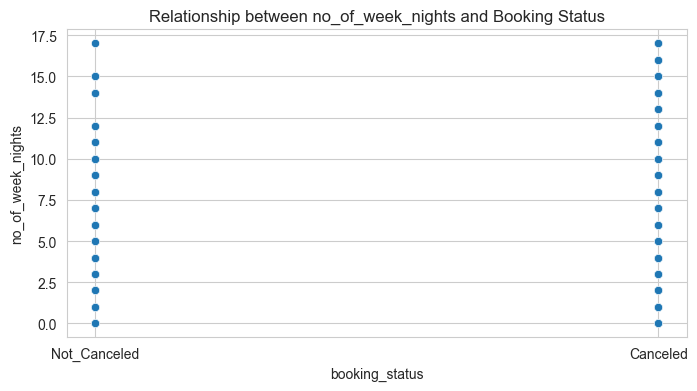

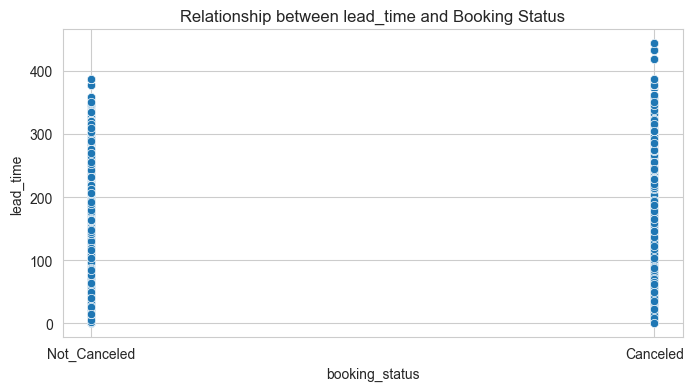

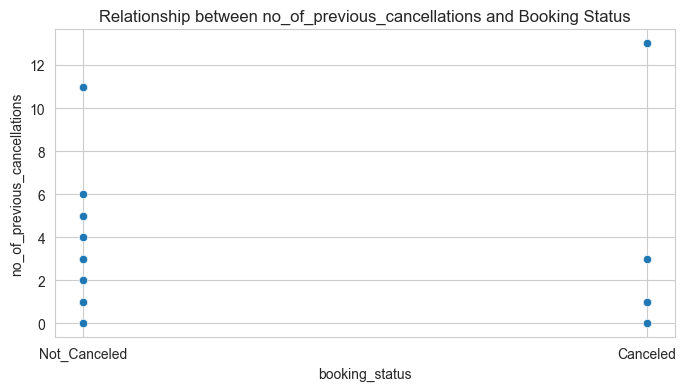

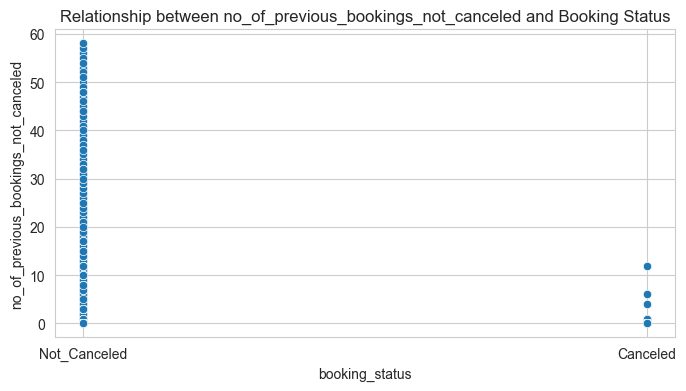

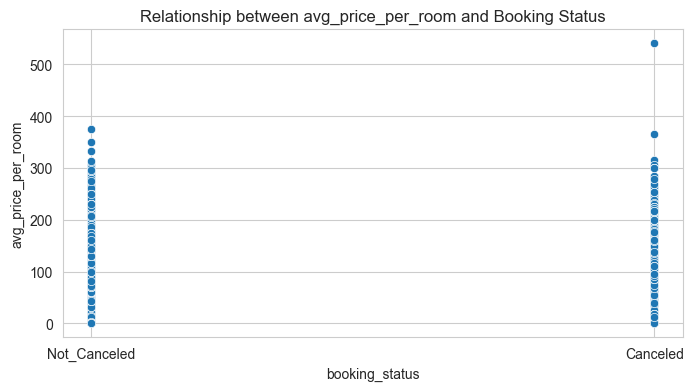

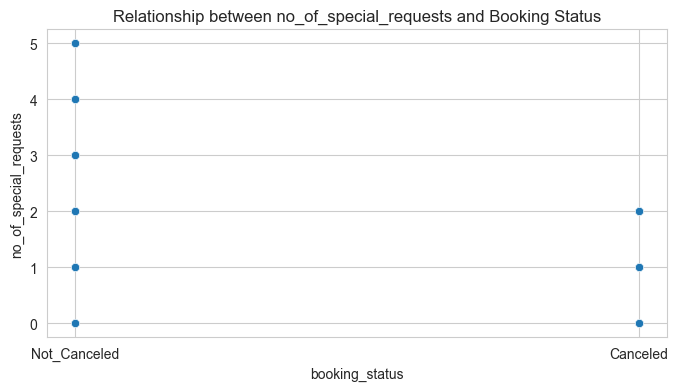

In [8]:
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x='booking_status', y=col, data=df)
    plt.title(f'Relationship between {col} and Booking Status')
    plt.show()

Features with relation to booking_status:
1. No_weekend_nights
2. No_of_special_requests
3. avg_price_per_room
4. no_of_previous_bookings_not_cancelled
5. lead_time
6. no_of_week_nights

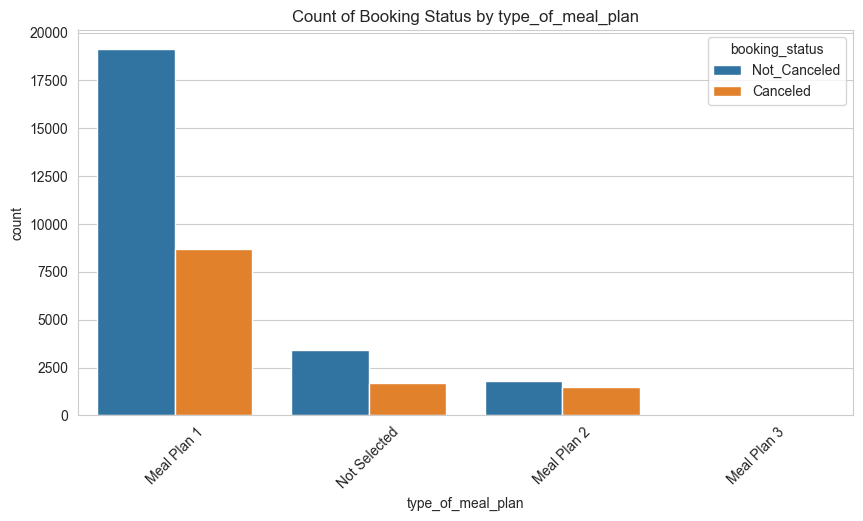

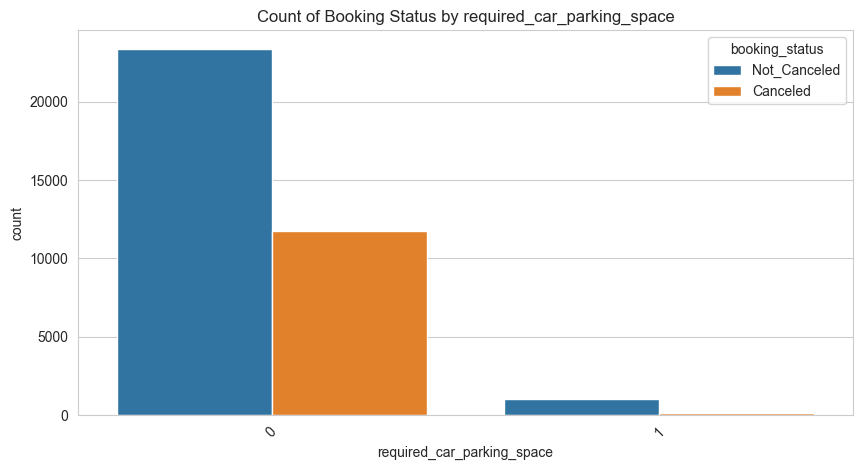

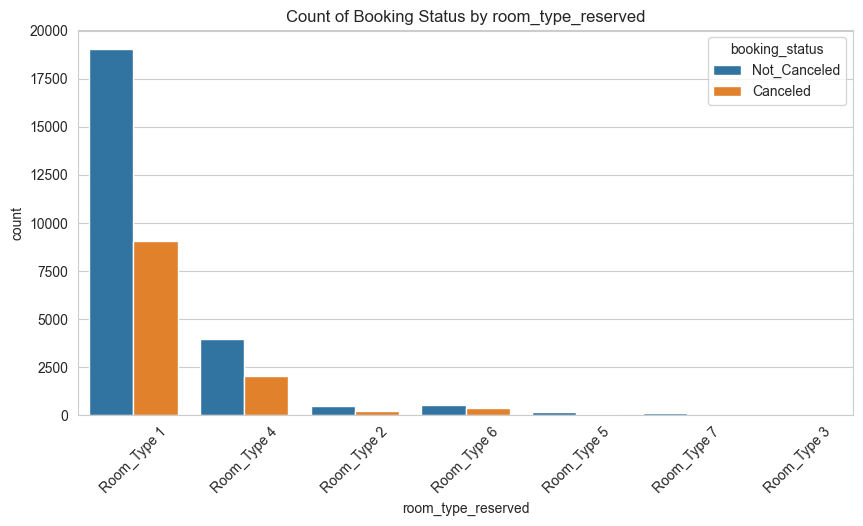

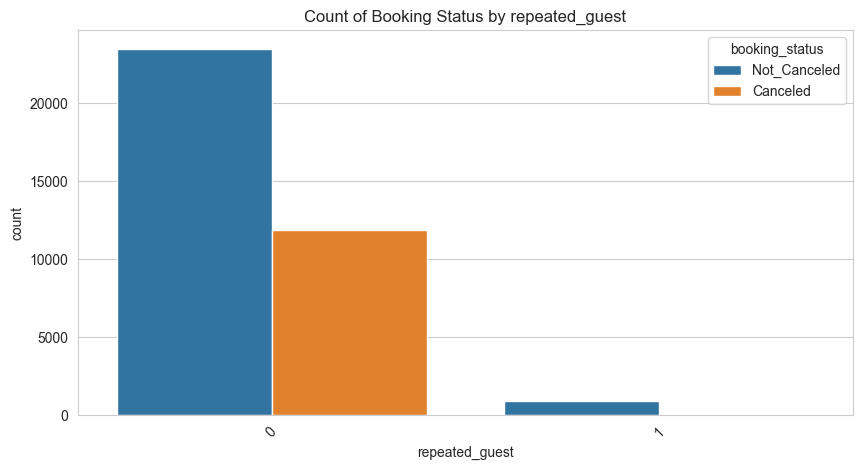

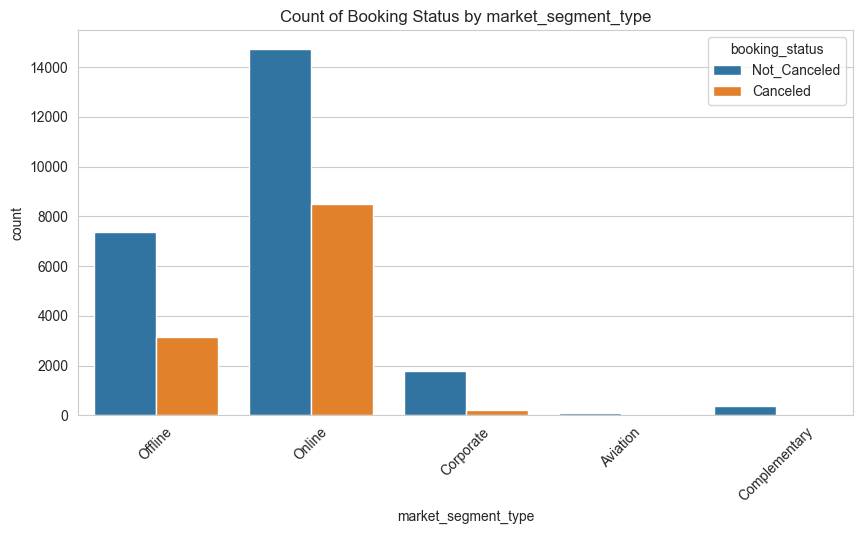

In [9]:
for col in object_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='booking_status', data=df)
    plt.title(f'Count of Booking Status by {col}')
    plt.xticks(rotation=45)
    plt.show()

In [10]:
df['booking_status'] = df['booking_status'].map({'Canceled': 0, 'Not_Canceled': 1})
df['market_segment_type'] = df['market_segment_type'].map({'Offline': 0, 'Online': 1, 'Corporate': 2, 'Aviation': 3, 'Complementary': 4
})
df['type_of_meal_plan'] = df['type_of_meal_plan'].map({'Not Selected': 0, 'Meal Plan 1': 1, 'Meal Plan 2': 2, 'Meal Plan 3': 3})
df['room_type_reserved'] = df['room_type_reserved'].map({'Room_Type 1': 1, 'Room_Type 2': 2, 'Room_Type 3': 3, 'Room_Type 4': 4, 'Room_Type 5': 5, 'Room_Type 6': 6, 'Room_Type 7': 7})


In [11]:
correlation_results = {}
for col in numeric_cols:
    correlation, p_value = pointbiserialr(df[col], df['booking_status'])
    correlation_results[col] = {'correlation': correlation, 'p_value': p_value}
for key, value in correlation_results.items():
    print(f"{key}: Correlation={value['correlation']}, P-value={value['p_value']}")


no_of_adults: Correlation=-0.08692029966010163, P-value=8.848338257334181e-62
no_of_children: Correlation=-0.03307782091227519, P-value=2.9476373767736104e-10
no_of_weekend_nights: Correlation=-0.06156253999572039, P-value=8.340701585769528e-32
no_of_week_nights: Correlation=-0.09299600868288611, P-value=1.727215875236822e-70
lead_time: Correlation=-0.43853791858838226, P-value=0.0
no_of_previous_cancellations: Correlation=0.033727803233766715, P-value=1.3152065000414637e-10
no_of_previous_bookings_not_canceled: Correlation=0.060179419775241924, P-value=1.8287364128787426e-30
avg_price_per_room: Correlation=-0.14256933929270968, P-value=5.230318924156054e-164
no_of_special_requests: Correlation=0.2530698054213169, P-value=0.0


In [12]:
for col in object_cols:
    contingency_table = pd.crosstab(df[col], df['booking_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic against {col}: {chi2}, p-value: {p}")

Chi-Square Statistic against type_of_meal_plan: 278.29490920586017, p-value: 4.951915406087789e-60
Chi-Square Statistic against required_car_parking_space: 268.3884673400529, p-value: 2.547649021543868e-60
Chi-Square Statistic against room_type_reserved: 57.33495179790707, p-value: 1.5627796772447482e-10
Chi-Square Statistic against repeated_guest: 416.09555137693894, p-value: 1.7270504808167525e-92
Chi-Square Statistic against market_segment_type: 814.1088652405568, p-value: 6.74876302455762e-175


In [14]:
df = pd.read_csv('cleaned.csv')


In [15]:
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,inn00001,2,0,1,2,meal plan 1,0,room_type 1,224,2017,10,2,offline,0,0,0,65.00,0,not_canceled
1,inn00002,2,0,2,3,not selected,0,room_type 1,5,2018,11,6,online,0,0,0,106.68,1,not_canceled
2,inn00003,1,0,2,1,meal plan 1,0,room_type 1,1,2018,2,28,online,0,0,0,60.00,0,canceled
3,inn00004,2,0,0,2,meal plan 1,0,room_type 1,211,2018,5,20,online,0,0,0,100.00,0,canceled
4,inn00005,2,0,1,1,not selected,0,room_type 1,48,2018,4,11,online,0,0,0,94.50,0,canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,inn36271,3,0,2,6,meal plan 1,0,room_type 4,85,2018,8,3,online,0,0,0,167.80,1,not_canceled
36271,inn36272,2,0,1,3,meal plan 1,0,room_type 1,228,2018,10,17,online,0,0,0,90.95,2,canceled
36272,inn36273,2,0,2,6,meal plan 1,0,room_type 1,148,2018,7,1,online,0,0,0,98.39,2,not_canceled
36273,inn36274,2,0,0,3,not selected,0,room_type 1,63,2018,4,21,online,0,0,0,94.50,0,canceled


In [16]:
df.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')